## Analyzing student test data

We are given with 5 collections from a MongoDB database
Each collection details are given below.

1. attempts: It holds summary data of student's attempt. Each test by a student becomes an attempt. If student takes 5 tests (same or different test), it will create 5 attempts. If student abandones the test, isAbandon flag is set to true. We consider only isAbandon = false documents. 

2. attemptDetails: Question level details such as time taken on each question can be found in this collection. Each attempt has a corresponding attemptDetails.

3. practicesets: List of tests. Array 'questions' holds list of questions. Test can be created organically or can be created from the questions of question pool.

4. questions: list of questions. One question can be part of many tests. Question can be put in the pool using flag 'isAllowReuse'

5. grades/subjects/topics - master data of exam, related subjects and topics

6. users: list of students including teachers and parents

## Objective:
1. Does more practice mean better performance?
2. Detect fraud done by some test takers. Fraud can be based on
    - Number of consecutive correct answers
    - Time spent on each questions when answer is correct
    - Time spent outside the test window (offscreen time)
    - Time spent by other users of similar profile on this question
    - Strength and weakness of the student on the topic
    - Time spent by the student on similar questions
3. Student clusters based on different attributes e.g. performance, time spent, consistency, participation in discussion etc
4. A teacher may mark a question easy/medium/hard (Perceived hardness) but we want to give feedback to teachers on what's real hardness based on student's data (how many students answered correctly, how much time taken, whether student was good in the area/topic etc. )
5. Predict score in a test and challenge student to beat it 

### In this notebook we will try to answer our first objective
### whether the students who has practiced more has better performance.

In [74]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# from pymongo import mongo_client
from pymongo import MongoClient
from pandas.io.json import json_normalize
import json
from sklearn.linear_model import LinearRegression
import warnings
warnings.filterwarnings('ignore')

In [2]:
# lets import the dataframes, which are created from collections using pymongo and pandas earlier.
attempts_df = pd.read_csv('attempts_df.csv')
attemptdetails_df = pd.read_csv('attemptdetails_df.csv')
users_df = pd.read_csv("users_df.csv")

## Data wrangling

In [3]:
# Lets see the first five rows of these 3 5 dataframes to get some sense of the data
attempts_df.head()

,__v,_id,attemptType,attemptdetails,createdAt,createdBy.name,createdBy.user,email,idOffline,isAbandoned,...,totalCorrects,totalErrors,totalMark,totalMarkeds,totalMissed,totalQuestions,totalTime,updatedAt,user,userId
0,0,5b851ffdb0a5d1ad413d8301,NaN,5b851ffdb0a5d17a103d8302,2018-08-28 09:23:57.839,teacherlpu,5b3e0266a14b7e000d9cc040,NaN,NaN,False,...,35,20,35.0,0,0,55,2887958,2018-08-28 10:12:25.489,5b82922edd6c9c6e6db00fb0,NaN
1,0,5b852003b0a5d136aa3d8371,NaN,5b852003b0a5d190863d8372,2018-08-28 09:17:11.950,teacherlpu,5b3e0266a14b7e000d9cc040,NaN,NaN,False,...,31,24,31.0,0,0,55,3300006,2018-08-28 10:12:39.239,5b829227dd6c9c4c7fb00da0,NaN
2,0,5b851ff7dd6c9c8cedb051d3,NaN,5b851ff7dd6c9c400eb051d4,2018-08-28 09:17:00.084,teacherlpu,5b3e0266a14b7e000d9cc040,NaN,NaN,False,...,25,9,25.0,0,21,55,3299999,2018-08-28 10:12:21.337,5b82922cdd6c9c2801b00f20,NaN
3,0,5b852014b0a5d10fc33d83e4,NaN,5b852014b0a5d11fd13d83e5,2018-08-28 09:17:28.725,teacherlpu,5b3e0266a14b7e000d9cc040,NaN,NaN,False,...,29,15,29.0,0,11,55,3300049,2018-08-28 10:12:59.708,5b82922add6c9c5f61b00e6a,NaN
4,0,5b85200948598b0aa6eabf57,NaN,5b85200948598b0d5beabf58,2018-08-28 09:17:16.906,teacherlpu,5b3e0266a14b7e000d9cc040,NaN,NaN,False,...,16,19,16.0,0,20,55,3300005,2018-08-28 10:12:38.440,5b82922edd6c9cd998b00f86,NaN


In [4]:
attemptdetails_df.head()

,QA,__v,_id,attempt,createdAt,isAbandoned,practicesetId,updatedAt,user
0,[{'question': ObjectId('5b82ecb0dd6c9c00e1b018...,0,5b83d566af15dcb2402312df,5b83d566af15dc6d322312de,2018-08-27 10:41:42.351,False,5b82ecb0dd6c9c3785b01856,2018-08-27 10:41:42.351,5b82922cdd6c9c67f5b00ef6
1,[{'question': ObjectId('5b82ecb0dd6c9c00e1b018...,0,5b83d5723a227f518ce1770b,5b83d5723a227f350be1770a,2018-08-27 10:41:54.195,False,5b82ecb0dd6c9c3785b01856,2018-08-27 10:41:54.195,5b82922edd6c9c0c57b00f90
2,[{'question': ObjectId('5b82ecb0dd6c9c00e1b018...,0,5b83d57edd6c9c2b7db02a8f,5b83d57edd6c9c8ec5b02a8e,2018-08-27 10:42:06.566,False,5b82ecb0dd6c9c3785b01856,2018-08-27 10:42:06.566,5b82922edd6c9c52c9b00fbe
3,[{'question': ObjectId('5b82ecb0dd6c9c00e1b018...,0,5b83d58648598b77a0ea8a2a,5b83d58548598bb42dea8a29,2018-08-27 10:42:14.080,False,5b82ecb0dd6c9c3785b01856,2018-08-27 10:42:14.080,5b82922edd6c9c55fbb00f92
4,[{'question': ObjectId('5b82ecb0dd6c9c00e1b018...,0,5b83d58c48598b0d31ea8a8c,5b83d58c48598bec32ea8a8b,2018-08-27 10:42:20.879,False,5b82ecb0dd6c9c3785b01856,2018-08-27 10:42:20.879,5b829227dd6c9c9dacb00da2


In [5]:
users_df.head()

,__v,_id,about,avatar._id,avatar.fileName,avatar.fileUrl,avatar.mimeType,avatar.path,avatar.size,avatarMD._id,...,state,status,streamUrl,street,studentExclusive,theme,trainingCertifications,updatedAt,userId,web
0,1,5ba5dd1b7fd1c520c12710ee,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,True,NaN,NaN,False,NaN,NaN,2018-09-22 06:11:39.601,s6o9mreasdhzdufo@gmail.com,NaN
1,2,5ba5dd1d7fd1c5a3fb2710f2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Punjab,True,NaN,NaN,False,NaN,NaN,2018-09-22 06:11:41.955,d8o2oank.iamna@gmail.com,NaN
2,2,5ba5dd217fd1c56a6e2710f8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Punjab,True,NaN,NaN,False,NaN,NaN,2018-09-22 06:11:45.281,9591871089,NaN
3,2,5ba5dd237fd1c5babe2710fd,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Punjab,True,NaN,NaN,False,NaN,NaN,2018-09-22 06:11:47.159,9819563408,NaN
4,1,5ba5de707fd1c552b32712cd,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,True,NaN,NaN,False,NaN,NaN,2018-09-22 06:17:20.076,9035735367,NaN


In [6]:
attempts_df.shape, attemptdetails_df.shape, users_df.shape

((35737, 43), (35737, 9), (6107, 80))

#### From above we can see there are lots of columns in all three dataframes which are not required for our analysis.
#### Also _id in users dataframe is a primary key which will act as foreign key in other dataframes.
#### Every _id in users dataframe has corresponding userId and lets see whether userId values are  unique or is there any duplicates present

In [7]:
users_df.columns

Index(['__v', '_id', 'about', 'avatar._id', 'avatar.fileName',
       'avatar.fileUrl', 'avatar.mimeType', 'avatar.path', 'avatar.size',
       'avatarMD._id', 'avatarMD.fileName', 'avatarMD.fileUrl',
       'avatarMD.mimeType', 'avatarMD.path', 'avatarMD.size', 'avatarSM._id',
       'avatarSM.fileName', 'avatarSM.fileUrl', 'avatarSM.mimeType',
       'avatarSM.path', 'avatarSM.size', 'birthdate', 'branch', 'city',
       'country.callingCodes', 'country.code', 'country.name', 'createdAt',
       'designation', 'district', 'educationDetails', 'email', 'emailStudents',
       'emailVerified', 'emailVerifyExpired', 'emailVerifyToken',
       'entranceExam', 'expertise', 'expiredDate', 'externalAssessment',
       'gender', 'grade', 'hashedPassword', 'identificationNumber',
       'institute', 'interest', 'interestedSubject', 'isActive', 'isPublic',
       'knowAboutUs', 'lastLogin', 'levelHistory', 'locations',
       'managerPractice', 'managerStudent', 'name', 'passingYear',
       'p

In [8]:
users_df = users_df[['_id','practiceAttempted','updatedAt','userId']]
users_df.head()

,_id,practiceAttempted,updatedAt,userId
0,5ba5dd1b7fd1c520c12710ee,[],2018-09-22 06:11:39.601,s6o9mreasdhzdufo@gmail.com
1,5ba5dd1d7fd1c5a3fb2710f2,[],2018-09-22 06:11:41.955,d8o2oank.iamna@gmail.com
2,5ba5dd217fd1c56a6e2710f8,[],2018-09-22 06:11:45.281,9591871089
3,5ba5dd237fd1c5babe2710fd,[],2018-09-22 06:11:47.159,9819563408
4,5ba5de707fd1c552b32712cd,[],2018-09-22 06:17:20.076,9035735367


In [9]:
users_df._id.duplicated().sum(), users_df.userId.duplicated().sum()

(0, 15)

In [10]:
# So there are like 15 duplicates lets look into those userId's
users_df[users_df.userId.duplicated(keep=False)]

,_id,practiceAttempted,updatedAt,userId
1272,5ba5c86623826634308f3d66,[],2018-09-22 04:43:18.602,9432472763
1322,5ba5c8662382664c1f8f3d67,[],2018-09-22 04:43:18.634,9432472763
1436,5ba5ccef238266a33e8f407c,[],2018-09-22 05:02:39.351,9982594518
1440,5ba5ccef23826641da8f407b,[],2018-09-22 05:02:39.317,9982594518
3489,5c08ac15f7bcf65556f2baec,[],2018-12-06 04:56:53.926,s7h9iavratmabh@gmail.com
3506,5c093d5f48b35cae24df8166,[],2018-12-06 15:16:47.615,akn.uadkeiep@gmail.com
3534,5c095527b84cbc79290b2a1d,[],2018-12-06 16:58:15.039,sah3i2v1ayndidre@gmail.com
3543,5c0a5ed30abd0061058afe30,[],2018-12-07 11:51:47.381,a3y3u7s.hr.apdod@gmail.com
3591,5c0092055e6efb28585aabc4,[],2018-11-30 01:27:33.597,trhaemruaktiinpaahlply@gmail.com
3821,5c0b30b1a6f75c3c2d8a0aea,[],2018-12-08 02:47:13.004,wiansaavdiehs@gmail.com


### so there are some duplicate userId's present lets keep the latest updated userId.
### For this lets sort out users dataframe updatedat column and later removing the first duplicate

In [11]:
users_df.sort_values('updatedAt', ascending=False, inplace=True)
users_df.head()

,_id,practiceAttempted,updatedAt,userId
6104,5c5f30e8fc459a7e480d56c3,[],2019-02-09 19:58:32.569,a4l1o4kira@gmail.com
6103,5c5ee905e463cb21fd783d23,[],2019-02-09 14:51:49.103,l9p0u116116@gmail.com
6102,5c5ed7f9408e7311f7d8883d,[],2019-02-09 13:39:05.695,r4a3h0u5l2s5i2n2gh@gmail.com
6101,5c5eb8aefc459a3db20d482c,[ObjectId('5be081a56ee33b8628c9e57d')],2019-02-09 11:25:34.515,p9u9nuedentahhc@gmail.com
6100,5c5eb2cc4c010c7082a228ed,[],2019-02-09 11:00:28.468,a2n1u5s2hyklaelvo@gamil.com


In [12]:
# now lets remove those duplicate userId observations.
users_df.drop_duplicates(subset='userId', inplace=True)
users_df.shape

(6092, 4)

In [13]:
# so duplicate userId observations are dropped.
# Now lets select important features from attempts dataframe
attempts_df.columns

Index(['__v', '_id', 'attemptType', 'attemptdetails', 'createdAt',
       'createdBy.name', 'createdBy.user', 'email', 'idOffline', 'isAbandoned',
       'isAnsync', 'isCratedOffline', 'isEvaluated', 'isShowAttempt',
       'isfraudelent', 'maximumMarks', 'minusMark', 'offscreenTime', 'partial',
       'pending', 'plusMark', 'practiceSetInfo.accessMode',
       'practiceSetInfo.classRooms', 'practiceSetInfo.createdBy',
       'practiceSetInfo.grades._id', 'practiceSetInfo.grades.level',
       'practiceSetInfo.grades.name', 'practiceSetInfo.subject',
       'practiceSetInfo.title', 'practiceSetInfo.titleLower', 'practicesetId',
       'studentName', 'subjects', 'totalCorrects', 'totalErrors', 'totalMark',
       'totalMarkeds', 'totalMissed', 'totalQuestions', 'totalTime',
       'updatedAt', 'user', 'userId'],
      dtype='object')

In [14]:
attempts_df['practiceSetInfo.grades.name'].value_counts()

Placement Readiness Tests                  30648
Programming                                 2319
Computer Science & Engineering              1571
Mechanical Engineering                       503
Electronics & Communication Engineering      466
Civil Engineering                            124
Electrical Engineering                       106
Name: practiceSetInfo.grades.name, dtype: int64

In [15]:
# for our first objective we only need the following features.
imp_features = ['_id','user','isAbandoned', 'maximumMarks', \
                'practiceSetInfo.grades.name', \
                'totalCorrects', 'totalErrors',\
                'totalMark', 'totalMissed', \
                'totalTime',]
attempts_df = attempts_df[imp_features]
attempts_df.head()

,_id,user,isAbandoned,maximumMarks,practiceSetInfo.grades.name,totalCorrects,totalErrors,totalMark,totalMissed,totalTime
0,5b851ffdb0a5d1ad413d8301,5b82922edd6c9c6e6db00fb0,False,55,Placement Readiness Tests,35,20,35.0,0,2887958
1,5b852003b0a5d136aa3d8371,5b829227dd6c9c4c7fb00da0,False,55,Placement Readiness Tests,31,24,31.0,0,3300006
2,5b851ff7dd6c9c8cedb051d3,5b82922cdd6c9c2801b00f20,False,55,Placement Readiness Tests,25,9,25.0,21,3299999
3,5b852014b0a5d10fc33d83e4,5b82922add6c9c5f61b00e6a,False,55,Placement Readiness Tests,29,15,29.0,11,3300049
4,5b85200948598b0aa6eabf57,5b82922edd6c9cd998b00f86,False,55,Placement Readiness Tests,16,19,16.0,20,3300005


In [16]:
# so we took only 8 important features for our analysis for attempts dataframe
# As attemptdetails has very less features, I think there is no need to drop any features
attemptdetails_df.head()

,QA,__v,_id,attempt,createdAt,isAbandoned,practicesetId,updatedAt,user
0,[{'question': ObjectId('5b82ecb0dd6c9c00e1b018...,0,5b83d566af15dcb2402312df,5b83d566af15dc6d322312de,2018-08-27 10:41:42.351,False,5b82ecb0dd6c9c3785b01856,2018-08-27 10:41:42.351,5b82922cdd6c9c67f5b00ef6
1,[{'question': ObjectId('5b82ecb0dd6c9c00e1b018...,0,5b83d5723a227f518ce1770b,5b83d5723a227f350be1770a,2018-08-27 10:41:54.195,False,5b82ecb0dd6c9c3785b01856,2018-08-27 10:41:54.195,5b82922edd6c9c0c57b00f90
2,[{'question': ObjectId('5b82ecb0dd6c9c00e1b018...,0,5b83d57edd6c9c2b7db02a8f,5b83d57edd6c9c8ec5b02a8e,2018-08-27 10:42:06.566,False,5b82ecb0dd6c9c3785b01856,2018-08-27 10:42:06.566,5b82922edd6c9c52c9b00fbe
3,[{'question': ObjectId('5b82ecb0dd6c9c00e1b018...,0,5b83d58648598b77a0ea8a2a,5b83d58548598bb42dea8a29,2018-08-27 10:42:14.080,False,5b82ecb0dd6c9c3785b01856,2018-08-27 10:42:14.080,5b82922edd6c9c55fbb00f92
4,[{'question': ObjectId('5b82ecb0dd6c9c00e1b018...,0,5b83d58c48598b0d31ea8a8c,5b83d58c48598bec32ea8a8b,2018-08-27 10:42:20.879,False,5b82ecb0dd6c9c3785b01856,2018-08-27 10:42:20.879,5b829227dd6c9c9dacb00da2


## Exploratory data analysis

### from the problem statement we know that we only work with test attempts where isAbandoned is set to False
### Lets see whether any student abandoned the test

In [17]:
attempts_df.isAbandoned.value_counts()

False    33946
True      1791
Name: isAbandoned, dtype: int64

1. so there are total 33946 observations where student took the complete test
2. and 1791 observations where students abondoned the test
3. So according to problem statement we only work with observations where student took test
4. So I will delete all the observation having isAbandoned equal to True

In [18]:
attempts_df.drop(attempts_df[attempts_df['isAbandoned'] == True].index, inplace=True)

In [19]:
# lets relook whether every observation with True Abandoned is deleted from dataframe
attempts_df.isAbandoned.value_counts()

False    33946
Name: isAbandoned, dtype: int64

1. from the statement it is given that if the same use has taken multiple tests, then it will be treated as multiple attempts
2. So lets group our datframe by 'userId', 'id' and 'user to see how many tests or attempts he made.

## Objective 1:  Does more practice mean better performance?
1. Here to answer this objective first we have to find what metric we have to use that represents practice of student.
2. Also what metric best describes the performance of the student.
3. Lets explore the dataset to get the answers of these two questions.

In [20]:
attempts_df.head()

,_id,user,isAbandoned,maximumMarks,practiceSetInfo.grades.name,totalCorrects,totalErrors,totalMark,totalMissed,totalTime
0,5b851ffdb0a5d1ad413d8301,5b82922edd6c9c6e6db00fb0,False,55,Placement Readiness Tests,35,20,35.0,0,2887958
1,5b852003b0a5d136aa3d8371,5b829227dd6c9c4c7fb00da0,False,55,Placement Readiness Tests,31,24,31.0,0,3300006
2,5b851ff7dd6c9c8cedb051d3,5b82922cdd6c9c2801b00f20,False,55,Placement Readiness Tests,25,9,25.0,21,3299999
3,5b852014b0a5d10fc33d83e4,5b82922add6c9c5f61b00e6a,False,55,Placement Readiness Tests,29,15,29.0,11,3300049
4,5b85200948598b0aa6eabf57,5b82922edd6c9cd998b00f86,False,55,Placement Readiness Tests,16,19,16.0,20,3300005


In [21]:
attempts_df['practiceSetInfo.grades.name'].value_counts()

Placement Readiness Tests                  29080
Programming                                 2208
Computer Science & Engineering              1521
Mechanical Engineering                       485
Electronics & Communication Engineering      438
Civil Engineering                            113
Electrical Engineering                       101
Name: practiceSetInfo.grades.name, dtype: int64

#### as we can see most of the tests are based on Placement Readiness Test
#### so lets starts our analysis with placement readiness Tests

In [22]:
placement_test_df = attempts_df[attempts_df['practiceSetInfo.grades.name'] == 'Placement Readiness Tests']

In [23]:
# lets check whether all the observations belong to placement readiness tests
placement_test_df['practiceSetInfo.grades.name'].value_counts()

Placement Readiness Tests    29080
Name: practiceSetInfo.grades.name, dtype: int64

#### Now we know that all the observations belong to placement readiness tests
#### So now we can say that if student attempt number of tests then he has practiced more 
#### So now we can take number of attempts as practice metric.
#### For performance metric we can take Total Marks as performance metric
#### In placiment readiness tests also there are several different subject tests student may take, So we will take average of total marks as performance metric
#### So now lets check whether the students who took more tests have more total marks.

In [24]:
placement_test_df.head()

,_id,user,isAbandoned,maximumMarks,practiceSetInfo.grades.name,totalCorrects,totalErrors,totalMark,totalMissed,totalTime
0,5b851ffdb0a5d1ad413d8301,5b82922edd6c9c6e6db00fb0,False,55,Placement Readiness Tests,35,20,35.0,0,2887958
1,5b852003b0a5d136aa3d8371,5b829227dd6c9c4c7fb00da0,False,55,Placement Readiness Tests,31,24,31.0,0,3300006
2,5b851ff7dd6c9c8cedb051d3,5b82922cdd6c9c2801b00f20,False,55,Placement Readiness Tests,25,9,25.0,21,3299999
3,5b852014b0a5d10fc33d83e4,5b82922add6c9c5f61b00e6a,False,55,Placement Readiness Tests,29,15,29.0,11,3300049
4,5b85200948598b0aa6eabf57,5b82922edd6c9cd998b00f86,False,55,Placement Readiness Tests,16,19,16.0,20,3300005


In [25]:
# AS we have already removed absorvations of attempts which were abandoned
# So isAbandoned column is no use for our analysis, as it only contains False values 
# indicating that attempt was not abandoned which is our primary assumption
# According to problems statements, so lets drop isAbandoned column.
placement_test_df.drop('isAbandoned', axis=1, inplace=True)
placement_test_df.head()

,_id,user,maximumMarks,practiceSetInfo.grades.name,totalCorrects,totalErrors,totalMark,totalMissed,totalTime
0,5b851ffdb0a5d1ad413d8301,5b82922edd6c9c6e6db00fb0,55,Placement Readiness Tests,35,20,35.0,0,2887958
1,5b852003b0a5d136aa3d8371,5b829227dd6c9c4c7fb00da0,55,Placement Readiness Tests,31,24,31.0,0,3300006
2,5b851ff7dd6c9c8cedb051d3,5b82922cdd6c9c2801b00f20,55,Placement Readiness Tests,25,9,25.0,21,3299999
3,5b852014b0a5d10fc33d83e4,5b82922add6c9c5f61b00e6a,55,Placement Readiness Tests,29,15,29.0,11,3300049
4,5b85200948598b0aa6eabf57,5b82922edd6c9cd998b00f86,55,Placement Readiness Tests,16,19,16.0,20,3300005


In [26]:
# lets see the correlations between features
placement_test_df.corr()

,maximumMarks,totalCorrects,totalErrors,totalMark,totalMissed,totalTime
maximumMarks,1.000000,0.555452,0.756152,0.547366,0.434078,0.656339
totalCorrects,0.555452,1.000000,0.241949,0.997196,-0.197989,0.393046
totalErrors,0.756152,0.241949,1.000000,0.232337,-0.010047,0.572360
totalMark,0.547366,0.997196,0.232337,1.000000,-0.198953,0.385715
totalMissed,0.434078,-0.197989,-0.010047,-0.198953,1.000000,0.168373
totalTime,0.656339,0.393046,0.572360,0.385715,0.168373,1.000000


#### observations:
1. total missed and totalMark features are negatively corelated, meaning that if the student missed more questions he wil get less total marks.
2. similarly totalMissed and totalCorrects are negatiely corelated, meaning if student miss more more quesitons totalCorrects will be reduced.
3. There is very high corelation of 0.99 between totalMarks and totalCorrects which obviously show that if student get more corrects then he will get more totalMarks
6. there is also 0.39 corelation between totalcorrects and totalTime taken.
7. corelation value of 0.57 exists between totalErrors and totalTime, which is interesting because it indicates students who took more time has made more errors.
8. We can also see that there is a great corelation of 0.75 between total errors and maximum marks, Here maximum marks is based on test, some test has maximum marks of 65, and some tests has maximum marks of only 10, so obviously the test which has more maximum marks has more questions so the student has more chance of making errors than compared to test which has less maximum marks.

### Now lets see the number of test attempts each user has in placement readiness test.

In [27]:
placement_test_df.groupby('user').count().sort_values('_id', ascending=False)['_id'].head(10)

user
5c0092275e6efb28585ab056    127
5c0092105e6efb28585aad54    106
5c0092595e6efb28585ab6c8    102
5c0092545e6efb28585ab637    100
5c0091f95e6efb28585aaa0c     84
5c00918a5e6efb28585a9909     83
5c0091d05e6efb28585aa3f9     77
5c0092715e6efb28585aba01     73
5c0092665e6efb28585ab88a     73
5c0091bc5e6efb28585aa0e8     72
Name: _id, dtype: int64

### from above we can see that there are total 3993 unique users
### lets group the placement test dataframe by unique users

1. From above we can see the user 5c0092275e6efb28585ab056 has taken 127 placement readiness tests.
2. similarily user 5c0091bc5e6efb28585aa0e8 has taken 72 placement readiness tests.
3. So for answering the first objective, we can think of practice as number of test attempts students had, if the student had more number of tests, then we can say he practiced more.
4. So we already counted how many attempts or tests each student took.
5. Now we can take average total Marks of each user for performance metric.
6. We can't directly take totalMarks as performance metrics because each student can take different subtest, Since all subtest belong to same placement readiness test, and totalMarks vary on each subtest, so taking average on all totalMarks of each test will be good here.

### From above attemptdetails we can see the number of attempts or tests each user took 

lets prepare a new dataframe which we can have our user, number of attempts and average total marks values

In [28]:
placement_test_df.groupby('user').count()['_id'].head(10)

user
5b4034ebaec16d000dd1f8d2     1
5b443b21b05807000d75f264     4
5b44463412012c000c237924     1
5b4b99ef083538000d9885cd     1
5b4b99ef083538000d9885cf     7
5b4b99ef083538000d9885d1    14
5b4b99ef083538000d9885d3     2
5b4b99ef083538000d9885d5     2
5b4b99ef083538000d9885d7     5
5b4b99ef083538000d9885d9     6
Name: _id, dtype: int64

In [30]:
placement_test_df.groupby('user').mean().head()

,maximumMarks,totalCorrects,totalErrors,totalMark,totalMissed,totalTime
user,,,,,,
5b4034ebaec16d000dd1f8d2,45.000000,1.000000,2.000000,1.000000,42.000000,4.952000e+04
5b443b21b05807000d75f264,35.000000,20.500000,12.000000,20.500000,2.500000,2.501583e+06
5b44463412012c000c237924,30.000000,19.000000,11.000000,19.000000,0.000000,1.508291e+06
5b4b99ef083538000d9885cd,45.000000,21.000000,22.000000,21.000000,2.000000,3.367600e+06
5b4b99ef083538000d9885cf,35.714286,9.714286,6.714286,9.714286,19.285714,1.395147e+06


In [33]:
numberOfAttempts = placement_test_df.groupby('user').count()['_id']
avgTotalMarks = placement_test_df.groupby('user').mean()

In [42]:
numberOfAttempts = numberOfAttempts.reset_index().rename({'_id':'numberOfAttempts'}, axis=1)
numberOfAttempts.head()

,user,numberOfAttempts
0,5b4034ebaec16d000dd1f8d2,1
1,5b443b21b05807000d75f264,4
2,5b44463412012c000c237924,1
3,5b4b99ef083538000d9885cd,1
4,5b4b99ef083538000d9885cf,7


In [44]:
# Now lets join both the number of attempts and avg total marks dataframe
final_df = numberOfAttempts.join(avgTotalMarks, on='user')
final_df.head()

,user,numberOfAttempts,maximumMarks,totalCorrects,totalErrors,totalMark,totalMissed,totalTime
0,5b4034ebaec16d000dd1f8d2,1,45.000000,1.000000,2.000000,1.000000,42.000000,4.952000e+04
1,5b443b21b05807000d75f264,4,35.000000,20.500000,12.000000,20.500000,2.500000,2.501583e+06
2,5b44463412012c000c237924,1,30.000000,19.000000,11.000000,19.000000,0.000000,1.508291e+06
3,5b4b99ef083538000d9885cd,1,45.000000,21.000000,22.000000,21.000000,2.000000,3.367600e+06
4,5b4b99ef083538000d9885cf,7,35.714286,9.714286,6.714286,9.714286,19.285714,1.395147e+06


In [48]:
final_df.shape, final_df.query('numberOfAttempts > 1').shape

((3993, 8), (2440, 8))

### From above we can see there are total 3993 users
### Out of total 3993 users, 2440 users has taken more than 2 attempts.
### We should only consider more than 2 attempts for our analsysis because we can't say student practiced until he took more than 2 tests in placement readiness tests.

In [54]:
practice_df = final_df.query("numberOfAttempts > 1")

1. now we have numbler of attempts and average of total marks each user has.
2. Lets check whether is there any relationship between number of attempts and totalCorrects, maximum Marks and totalMissed

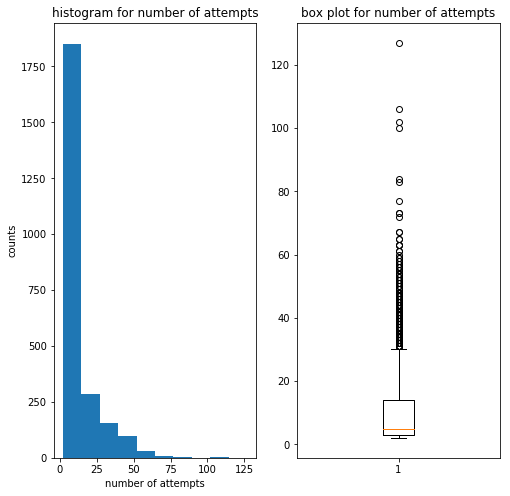

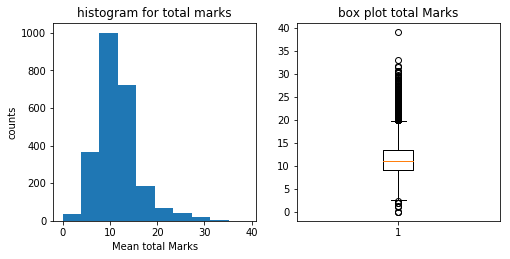

In [55]:
# now lets see the distribution of totalMarks and number of attempts
plt.figure(figsize=(8,8))
plt.subplot(1,2,1);
plt.hist(practice_df.numberOfAttempts);
plt.xlabel("number of attempts")
plt.ylabel("counts");
plt.title("histogram for number of attempts")

plt.subplot(1,2,2);
plt.boxplot(practice_df.numberOfAttempts);
plt.title("box plot for number of attempts");

plt.figure(figsize=(8,8))
plt.subplot(2,2,1);
plt.hist(practice_df.totalMark);
plt.xlabel("Mean total Marks")
plt.ylabel("counts");
plt.title("histogram for total marks")

plt.subplot(2,2,2);
plt.boxplot(practice_df.totalMark);
plt.title("box plot total Marks");

In [58]:
practice_df.numberOfAttempts.describe()

count    2440.000000
mean       11.281557
std        13.363397
min         2.000000
25%         3.000000
50%         5.000000
75%        14.000000
max       127.000000
Name: numberOfAttempts, dtype: float64

In [59]:
practice_df.query('numberOfAttempts>20')['numberOfAttempts'].shape[0]/practice_df['numberOfAttempts'].shape[0]

0.1680327868852459

### we can see 75% of students has attempted placement readiness test upto 14 times.
### but there are also 16.8% students who has attempted more than 20 times

-0.04472925879297789


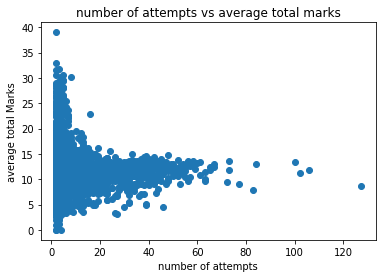

In [60]:
print(practice_df['numberOfAttempts'].corr(practice_df.totalMark))
plt.scatter(practice_df['numberOfAttempts'], practice_df.totalMark);
plt.xlabel('number of attempts')
plt.ylabel('average total Marks')
plt.title("number of attempts vs average total marks");

### So there is nearly zero corelation between number of attempts and average total marks
### but we need to dig further to see whats really happening.

### lets see whether the low number of test attempt users are effecting th results as there are 50% test takers who have less than 5 attempts

In [69]:
higher_attempts_practice_df = practice_df.query('numberOfAttempts>10')

In [70]:
higher_attempts_practice_df.shape

(757, 8)

0.08536207233649638


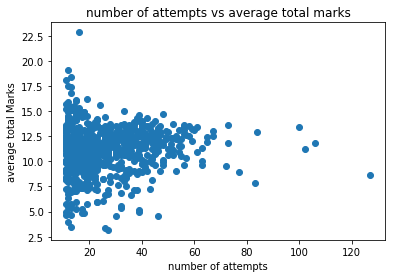

In [71]:
print(higher_attempts_practice_df.numberOfAttempts.corr(higher_attempts_practice_df.totalMark))
plt.scatter(higher_attempts_practice_df['numberOfAttempts'], higher_attempts_practice_df.totalMark);
#plt.plot([0,40] ,[0,25])
plt.xlabel('number of attempts')
plt.ylabel('average total Marks')
plt.title("number of attempts vs average total marks");

#### As we can see when we only consider high attempts where number of total attempts is greater than 10 with respespective to total marks, we can see the positive corelation has increased from -0.04 to 0.08

####  Even though the positive corelation increased we can't just infer that because of the student took more tests doesn't mean he has better performance, in this case total average marks.
#### We should do further detailed analysis to infer the realtionship between practice and performance

# Infer the relationship using machine learning linear regression Model

### so there are total 4126 tests with more than 2 attempts
### Now lets consider total marks as our performance metric
### lets see taking more number of tests has increased student performance or total marks

In [93]:
clf = LinearRegression()
clf.fit(practice_df['numberOfAttempts'].values.reshape(-1,1), practice_df['totalMark'].values)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [95]:
clf.intercept_

11.747914403575841

In [96]:
placement_test_df.head()

,_id,user,maximumMarks,practiceSetInfo.grades.name,totalCorrects,totalErrors,totalMark,totalMissed,totalTime
0,5b851ffdb0a5d1ad413d8301,5b82922edd6c9c6e6db00fb0,55,Placement Readiness Tests,35,20,35.0,0,2887958
1,5b852003b0a5d136aa3d8371,5b829227dd6c9c4c7fb00da0,55,Placement Readiness Tests,31,24,31.0,0,3300006
2,5b851ff7dd6c9c8cedb051d3,5b82922cdd6c9c2801b00f20,55,Placement Readiness Tests,25,9,25.0,21,3299999
3,5b852014b0a5d10fc33d83e4,5b82922add6c9c5f61b00e6a,55,Placement Readiness Tests,29,15,29.0,11,3300049
4,5b85200948598b0aa6eabf57,5b82922edd6c9cd998b00f86,55,Placement Readiness Tests,16,19,16.0,20,3300005


In [135]:
testinfo = placement_test_df[["user","totalMark"]]
improved = 0
improved_user = []
improved_attempts = []
not_improved = 0
not_improved_user = []
not_improved_attempts = []
metrics = []

for x in placement_test_df["user"].unique():
    temp_testinfo = placement_test_df[placement_test_df["user"] == x]
    rows = temp_testinfo.shape[0]
    if rows > 1:
        clf = LinearRegression()
        X = np.arange(rows).reshape(-1, 1)
        y = temp_testinfo["totalMark"]
        clf.fit(X, y)
        #initial_marks = temp_testinfo.iloc[0]["totalMark"]
        #latest_marks = temp_testinfo.iloc[-1]["totalMark"]
        tests_taken = temp_testinfo.shape[0]
        metrics.append((y, clf.coef_, clf.intercept_))
        if clf.coef_ > 0:
            improved += 1
            improved_user.append(x)
            improved_attempts.append(tests_taken)
        else:
            not_improved += 1
            not_improved_user.append(x)
            not_improved_attempts.append(tests_taken)
print("Improved: {} Not Improved: {}".format(improved, not_improved))

Improved: 1370 Not Improved: 1070


In [163]:
metrics.sort(key=lambda x: x[1], reverse=True)

#### lets see the top 5 student improvements based on attempts

Top 5 student improvements


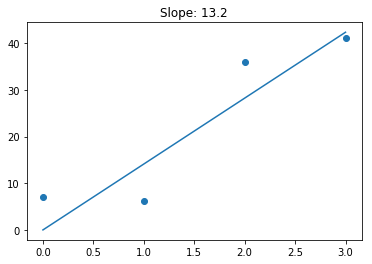

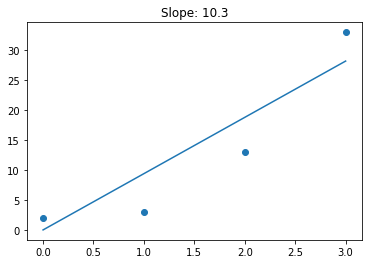

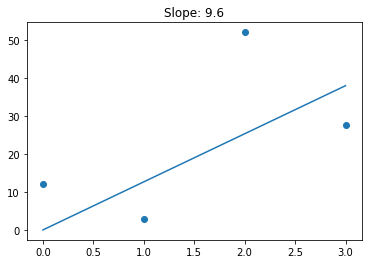

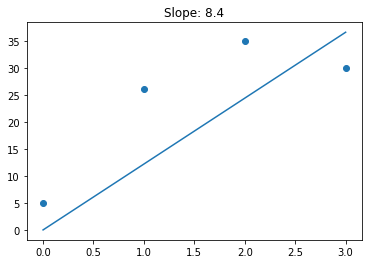

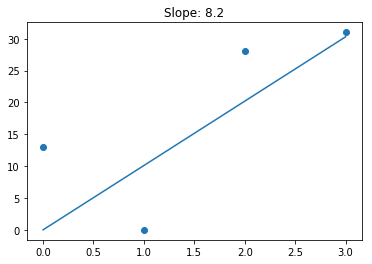

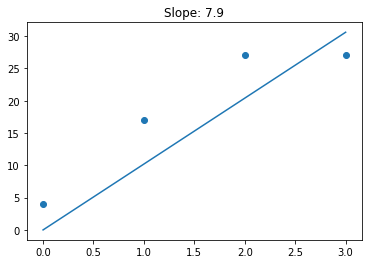

In [164]:
import matplotlib.pyplot as plt
%matplotlib inline

ctr = 0
print("Top 5 student improvements")

for x in metrics:
    if ctr > 5:
        break
    if len(x[0]) > 3:
        ctr += 1
        plt.scatter(np.arange(len(x[0])), x[0])
        plt.plot([0, 3], [0, x[1] * 3 + x[2]])
        plt.title("Slope: {0:.1f}".format(x[1][0]))
        plt.show()

In [136]:
practice_df.shape

(2440, 8)

### From above we can see out of 2440,  1370 students performance increased due to increase in number of attempts
### 1070 students performance didn't improve even in increase of number of attempts.

In [138]:
aa = pd.DataFrame({'user':improved_user, 'improved_attempts':improved_attempts})
bb = pd.DataFrame({'user':not_improved_user, 'not_improved_attempts':not_improved_attempts})

In [139]:
improved_df = aa.set_index("user").join(practice_df.set_index("user"), on='user')
not_improved_df = bb.set_index("user").join(practice_df.set_index("user"), on='user')

In [140]:
not_improved_df.head()

,not_improved_attempts,numberOfAttempts,maximumMarks,totalCorrects,totalErrors,totalMark,totalMissed,totalTime
user,,,,,,,,
5b82922edd6c9c6e6db00fb0,3,3,40.000000,20.666667,19.333333,20.666667,0.000000,2.358370e+06
5b829227dd6c9c4c7fb00da0,5,5,46.000000,20.000000,14.800000,20.000000,11.200000,2.940009e+06
5b82922cdd6c9c2801b00f20,2,2,32.500000,15.000000,4.500000,15.000000,13.000000,2.400013e+06
5b82922add6c9c5f61b00e6a,7,7,42.142857,23.571429,10.285714,23.571429,8.285714,2.585687e+06
5b82922edd6c9cd998b00f86,12,12,25.000000,9.500000,6.250000,9.500000,9.250000,1.527360e+06


In [131]:
improved_df.head()

,improved_attempts,numberOfAttempts,maximumMarks,totalCorrects,totalErrors,totalMark,totalMissed,totalTime
user,,,,,,,,
5b829223dd6c9cf5adb00cb4,5,5,44.0,19.400000,11.800000,19.400000,12.800000,2.919209e+06
5b829223dd6c9c1aceb00ca0,3,3,55.0,18.666667,18.666667,18.666667,17.666667,2.179794e+06
5b829228dd6c9c73eeb00e14,3,3,55.0,14.333333,40.333333,14.333333,0.333333,1.901014e+06
5b82922add6c9c71b8b00e94,3,3,55.0,23.666667,31.333333,23.666667,0.000000,2.729435e+06
5b829226dd6c9cfa8fb00d4c,4,4,55.0,27.000000,27.500000,27.000000,0.500000,1.963410e+06


#### Now lets add a column named performance to both improved and not improved dataframes
#### improved dataframe and not_improved dataframe will have 'improved' value and 'not improved' in performance columns as target variables.

In [145]:
improved_df['performance'] = 'improved'
not_improved_df['performance'] = 'not_improved'

In [146]:
improved_df.head()

,improved_attempts,numberOfAttempts,maximumMarks,totalCorrects,totalErrors,totalMark,totalMissed,totalTime,performance
user,,,,,,,,,
5b829223dd6c9cf5adb00cb4,5,5,44.0,19.400000,11.800000,19.400000,12.800000,2.919209e+06,improved
5b829223dd6c9c1aceb00ca0,3,3,55.0,18.666667,18.666667,18.666667,17.666667,2.179794e+06,improved
5b829228dd6c9c73eeb00e14,3,3,55.0,14.333333,40.333333,14.333333,0.333333,1.901014e+06,improved
5b82922add6c9c71b8b00e94,3,3,55.0,23.666667,31.333333,23.666667,0.000000,2.729435e+06,improved
5b829226dd6c9cfa8fb00d4c,4,4,55.0,27.000000,27.500000,27.000000,0.500000,1.963410e+06,improved


In [147]:
not_improved_df.head()

,not_improved_attempts,numberOfAttempts,maximumMarks,totalCorrects,totalErrors,totalMark,totalMissed,totalTime,performance
user,,,,,,,,,
5b82922edd6c9c6e6db00fb0,3,3,40.000000,20.666667,19.333333,20.666667,0.000000,2.358370e+06,not_improved
5b829227dd6c9c4c7fb00da0,5,5,46.000000,20.000000,14.800000,20.000000,11.200000,2.940009e+06,not_improved
5b82922cdd6c9c2801b00f20,2,2,32.500000,15.000000,4.500000,15.000000,13.000000,2.400013e+06,not_improved
5b82922add6c9c5f61b00e6a,7,7,42.142857,23.571429,10.285714,23.571429,8.285714,2.585687e+06,not_improved
5b82922edd6c9cd998b00f86,12,12,25.000000,9.500000,6.250000,9.500000,9.250000,1.527360e+06,not_improved


In [150]:
# not_improved_attempts and numberOfAttempts columns both should be equal, lets check them and remove one column
print((not_improved_df.not_improved_attempts == not_improved_df.numberOfAttempts).sum() == not_improved_df.shape[0])
print((improved_df.improved_attempts == improved_df.numberOfAttempts).sum() == improved_df.shape[0])

True
True


In [153]:
#since both the columns belong to number of attempts, lets remove one column
improved_df.drop('improved_attempts', axis=1, inplace=True)
not_improved_df.drop('not_improved_attempts', axis=1, inplace=True)

In [158]:
# Now lets join both the improved_df and not_improved_df to single dataframe.
placement_performance_df = pd.concat([improved_df, not_improved_df])

In [161]:
# lets sort the values using user feature
placement_performance_df = placement_performance_df.sort_index()

In [162]:
placement_performance_df.head()

,numberOfAttempts,maximumMarks,totalCorrects,totalErrors,totalMark,totalMissed,totalTime,performance
user,,,,,,,,
5b443b21b05807000d75f264,4,35.000000,20.500000,12.000000,20.500000,2.500000,2.501583e+06,improved
5b4b99ef083538000d9885cf,7,35.714286,9.714286,6.714286,9.714286,19.285714,1.395147e+06,improved
5b4b99ef083538000d9885d1,14,26.071429,11.142857,13.642857,10.928571,1.285714,8.552166e+05,improved
5b4b99ef083538000d9885d3,2,37.500000,17.000000,13.500000,17.000000,7.000000,1.983042e+06,not_improved
5b4b99ef083538000d9885d5,2,45.000000,9.500000,4.000000,9.500000,31.500000,3.261012e+06,improved


In [165]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

In [172]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test=train_test_split(placement_performance_df.iloc[:,:-1],placement_performance_df.performance ,test_size=0.3)

In [179]:
print(y_train.value_counts(normalize=True))
print(y_test.value_counts(normalize=True))

improved        0.564988
not_improved    0.435012
Name: performance, dtype: float64
improved        0.553279
not_improved    0.446721
Name: performance, dtype: float64


### LOGISTIC REGRESSION MODEL

In [187]:
grid={"C":np.logspace(-3,3,7), "penalty":["l1","l2"]}# l1 lasso l2 ridge
logreg=LogisticRegression()
logreg_cv=GridSearchCV(logreg, grid, cv=10)
logreg_cv.fit(x_train,y_train)

print("tuned hpyerparameters :(best parameters) ",logreg_cv.best_params_)
print("accuracy :",logreg_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'C': 0.01, 'penalty': 'l1'}
accuracy : 0.6065573770491803


In [185]:
from sklearn.metrics import accuracy_score

In [188]:
logreg_predict = logreg_cv.predict(x_test)
accuracy_score(logreg_predict, y_test)

0.5833333333333334

### K-NN

In [190]:
list(range(1,30,2))

[1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29]

In [191]:
from sklearn.neighbors import KNeighborsClassifier

In [193]:
grid= {'n_neighbors':list(range(1,30,2)), 'leaf_size':[1,3,5] } 
knn=KNeighborsClassifier()
knn_cv=GridSearchCV(knn, grid, cv=10)
knn_cv.fit(x_train,y_train)

print("tuned hpyerparameters :(best parameters) ",knn_cv.best_params_)
print("accuracy :",knn_cv.best_score_)
knn_predict = knn_cv.predict(x_test)
accuracy_score(knn_predict, y_test)                          

tuned hpyerparameters :(best parameters)  {'leaf_size': 1, 'n_neighbors': 11}
accuracy : 0.5597189695550351


0.5368852459016393

### Naive bayes

In [202]:
from sklearn.naive_bayes import BernoulliNB

In [203]:
grid= {'alpha':list(np.logspace(np.log(0.00005), np.log(10000))), 'fit_prior':['True','False']} 
bnb=BernoulliNB()
bnb_cv=GridSearchCV(mnb, grid, cv=10)
bnb_cv.fit(x_train,y_train)

print("tuned hpyerparameters :(best parameters) ",bnb_cv.best_params_)
print("accuracy :",bnb_cv.best_score_)
bnb_predict = bnb_cv.predict(x_test)
print(accuracy_score(bnb_predict, y_test))

tuned hpyerparameters :(best parameters)  {'alpha': 1.248856237976641e-10, 'fit_prior': 'True'}
accuracy : 0.5737704918032787
0.5368852459016393


o